# CWE Classification & Misclassification Analysis

This notebook analyzes CWE classification patterns and misclassification trends across different LLM models.

## Key Questions:
1. What CWEs are predicted most frequently by each model?
2. What are the common misclassification patterns in each model?
3. Which CWE types are hardest to classify correctly?
4. How do models compare in their classification accuracy?

## Data Sources:
- Model predictions: `diff_analysis_results/`
- Ground truth CWEs: `../datasets/snyk_and_advisory.csv`

In [1]:
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

In [2]:
# Configuration
RESULTS_DIR = Path('./diff_analysis_results/')
GROUND_TRUTH_PATH = Path('../datasets/snyk_and_advisory.csv')

print(f"Results directory exists: {RESULTS_DIR.exists()}")
print(f"Ground truth file exists: {GROUND_TRUTH_PATH.exists()}")

Results directory exists: True
Ground truth file exists: True


## 1. Load Ground Truth CWE Data

Load the snyk_and_advisory.csv to get all CWEs associated with each vulnerability ID and package.

In [3]:
# Load ground truth data
ground_truth_df = pd.read_csv(GROUND_TRUTH_PATH)
print(f"Ground truth dataset shape: {ground_truth_df.shape}")
print(f"\nColumns: {ground_truth_df.columns.tolist()}")
ground_truth_df.head()

Ground truth dataset shape: (30572, 10)

Columns: ['ID', 'Package', 'CWE', 'CVE', 'Date', 'Disclosed_Date', 'Platform', 'Version Range', 'GitHub URL', 'Source']


,ID,Package,CWE,CVE,Date,Disclosed_Date,Platform,Version Range,GitHub URL,Source
0,SNYK-DOTNET-MAGICKNETCORE-7856102,magick.net.core,CWE-122,CVE-2023-4863,1 Sep 2024,11 Sep 2023,NuGet,"['[,13.3.0)']",https://github.com/dlemstra/Magick.NET,Snyk
1,SNYK-DOTNET-SERILOGENRICHERSCLIENTINFO-7853254,serilog.enrichers.clientinfo,CWE-348,CVE-2024-44930,30 Aug 2024,29 Aug 2024,NuGet,"['[,2.1.0)']",https://github.com/serilog-contrib/serilog-enr...,Snyk
2,SNYK-DOTNET-RESTSHARP-7853196,restsharp,CWE-113,CVE-2024-45302,30 Aug 2024,29 Aug 2024,NuGet,"['[107.0.0-preview.1,112.0.0)']",https://github.com/restsharp/RestSharp,Snyk
3,SNYK-DOTNET-BOUNCYCASTLE-7831269,bouncycastle,CWE-835,CVE-2024-30172,26 Aug 2024,12 Apr 2024,NuGet,"['[0,]']",NaN,Snyk
4,SNYK-DOTNET-BOUNCYCASTLE-7831267,bouncycastle,CWE-203,CVE-2024-30171,26 Aug 2024,11 Apr 2024,NuGet,"['[0,]']",NaN,Snyk


In [4]:
def build_cwe_mapping(ground_truth_df):
    """
    Build mappings from:
    1. vuln_id -> list of CWEs
    2. package -> list of CWEs
    
    Each vulnerability ID and package may have multiple associated CWEs.
    """
    # vuln_id (ID column) -> CWEs
    vuln_to_cwes = defaultdict(set)
    for _, row in ground_truth_df.iterrows():
        vuln_id = row['ID']
        cwe = row.get('CWE')
        if pd.notna(cwe) and cwe:
            vuln_to_cwes[vuln_id].add(str(cwe))
    
    # package -> CWEs
    pkg_to_cwes = defaultdict(set)
    for _, row in ground_truth_df.iterrows():
        package = str(row['Package']).lower().strip()
        cwe = row.get('CWE')
        if pd.notna(cwe) and cwe:
            pkg_to_cwes[package].add(str(cwe))
    
    # Convert sets to sorted lists
    vuln_to_cwes = {k: sorted(list(v)) for k, v in vuln_to_cwes.items()}
    pkg_to_cwes = {k: sorted(list(v)) for k, v in pkg_to_cwes.items()}
    
    return vuln_to_cwes, pkg_to_cwes


vuln_to_cwes, pkg_to_cwes = build_cwe_mapping(ground_truth_df)

print(f"Vulnerabilities with CWE mappings: {len(vuln_to_cwes)}")
print(f"Packages with CWE mappings: {len(pkg_to_cwes)}")

# Show some examples
print("\nSample vuln_id -> CWEs mapping:")
for i, (vid, cwes) in enumerate(list(vuln_to_cwes.items())[:5]):
    print(f"  {vid}: {cwes}")

Vulnerabilities with CWE mappings: 29206
Packages with CWE mappings: 16267

Sample vuln_id -> CWEs mapping:
  SNYK-DOTNET-MAGICKNETCORE-7856102: ['CWE-122']
  SNYK-DOTNET-SERILOGENRICHERSCLIENTINFO-7853254: ['CWE-348']
  SNYK-DOTNET-RESTSHARP-7853196: ['CWE-113']
  SNYK-DOTNET-BOUNCYCASTLE-7831269: ['CWE-835']
  SNYK-DOTNET-BOUNCYCASTLE-7831267: ['CWE-203']


## 2. Load Model Predictions

In [5]:
def load_results(results_dir: Path) -> list:
    """Load all JSON result files from a directory."""
    results = []
    for json_file in results_dir.glob('*.json'):
        if json_file.name in ['analysis_summary.json', 'analysis_results.csv']:
            continue
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
                results.append(data)
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    return results


def parse_model_name(dir_name: str) -> tuple:
    """Parse directory name to extract model name and mode."""
    if dir_name.endswith('_vulnerable'):
        return dir_name[:-11], 'vulnerable'
    elif dir_name.endswith('_patched'):
        return dir_name[:-8], 'patched'
    else:
        return dir_name, 'unknown'


# Load all results
all_results = {}
result_dirs = [d for d in RESULTS_DIR.iterdir() if d.is_dir()]

for result_dir in sorted(result_dirs):
    model_name, mode = parse_model_name(result_dir.name)
    key = (model_name, mode)
    results = load_results(result_dir)
    all_results[key] = results
    print(f"Loaded {len(results):>4} results for {model_name:<25} ({mode})")

Loaded  582 results for codegemma:7b              (patched)
Loaded  582 results for codegemma:7b              (vulnerable)
Loaded  582 results for deepseek-coder-v2:16b     (patched)
Loaded  582 results for deepseek-coder-v2:16b     (vulnerable)
Loaded  582 results for deepseek-r1:70b           (patched)
Loaded  582 results for deepseek-r1:70b           (vulnerable)
Loaded  582 results for gpt-4o                    (patched)
Loaded  582 results for gpt-4o                    (vulnerable)
Loaded  582 results for gpt-5.1                   (patched)
Loaded  582 results for gpt-5.1                   (vulnerable)
Loaded  582 results for llama2:70b                (patched)
Loaded  582 results for llama2:70b                (vulnerable)
Loaded  582 results for llama3.3                  (patched)
Loaded  582 results for llama3.3                  (vulnerable)
Loaded  582 results for mixtral:8x7b              (patched)
Loaded  582 results for mixtral:8x7b              (vulnerable)
Loaded  582 resu

## 3. Filter Common Vulnerability IDs Across All Models

To ensure fair comparison, we only analyze vulnerability IDs that are present in ALL models.

In [6]:
def get_common_vuln_ids(all_results):
    """Find vulnerability IDs that are common across ALL model-mode combinations."""
    vuln_id_sets = []
    
    for (model, mode), results in all_results.items():
        vuln_ids = set(r['vuln_id'] for r in results if 'vuln_id' in r)
        vuln_id_sets.append(vuln_ids)
        print(f"{model:<25} ({mode:<10}): {len(vuln_ids)} vuln IDs")
    
    if not vuln_id_sets:
        return set()
    
    common_ids = vuln_id_sets[0]
    for s in vuln_id_sets[1:]:
        common_ids = common_ids.intersection(s)
    
    return common_ids


common_vuln_ids = get_common_vuln_ids(all_results)
print(f"\n{'='*60}")
print(f"Common vulnerability IDs across ALL models: {len(common_vuln_ids)}")

codegemma:7b              (patched   ): 582 vuln IDs
codegemma:7b              (vulnerable): 582 vuln IDs
deepseek-coder-v2:16b     (patched   ): 582 vuln IDs
deepseek-coder-v2:16b     (vulnerable): 582 vuln IDs
deepseek-r1:70b           (patched   ): 582 vuln IDs
deepseek-r1:70b           (vulnerable): 582 vuln IDs
gpt-4o                    (patched   ): 582 vuln IDs
gpt-4o                    (vulnerable): 582 vuln IDs
gpt-5.1                   (patched   ): 582 vuln IDs
gpt-5.1                   (vulnerable): 582 vuln IDs
llama2:70b                (patched   ): 582 vuln IDs
llama2:70b                (vulnerable): 582 vuln IDs
llama3.3                  (patched   ): 582 vuln IDs
llama3.3                  (vulnerable): 582 vuln IDs
mixtral:8x7b              (patched   ): 582 vuln IDs
mixtral:8x7b              (vulnerable): 582 vuln IDs
phi3:14b                  (patched   ): 582 vuln IDs
phi3:14b                  (vulnerable): 582 vuln IDs
qwen2.5-coder:32b         (patched   ): 582 vu

In [7]:
def filter_results_by_vuln_ids(all_results, common_ids):
    """Filter results to only include common vulnerability IDs."""
    filtered = {}
    for key, results in all_results.items():
        filtered[key] = [r for r in results if r.get('vuln_id') in common_ids]
    return filtered


filtered_results = filter_results_by_vuln_ids(all_results, common_vuln_ids)

# Verify filtering
print("Results after filtering to common vuln IDs:")
for (model, mode), results in sorted(filtered_results.items()):
    print(f"  {model:<25} ({mode:<10}): {len(results)} results")

Results after filtering to common vuln IDs:
  codegemma:7b              (patched   ): 582 results
  codegemma:7b              (vulnerable): 582 results
  deepseek-coder-v2:16b     (patched   ): 582 results
  deepseek-coder-v2:16b     (vulnerable): 582 results
  deepseek-r1:70b           (patched   ): 582 results
  deepseek-r1:70b           (vulnerable): 582 results
  gpt-4o                    (patched   ): 582 results
  gpt-4o                    (vulnerable): 582 results
  gpt-5.1                   (patched   ): 582 results
  gpt-5.1                   (vulnerable): 582 results
  llama2:70b                (patched   ): 582 results
  llama2:70b                (vulnerable): 582 results
  llama3.3                  (patched   ): 582 results
  llama3.3                  (vulnerable): 582 results
  mixtral:8x7b              (patched   ): 582 results
  mixtral:8x7b              (vulnerable): 582 results
  phi3:14b                  (patched   ): 582 results
  phi3:14b                  (vulnerabl

## 4. Build CWE Classification Dataset

Create a structured dataset with:
- Vulnerability ID
- Package
- Actual CWEs (ground truth)
- Predicted CWE by each model (from vulnerable mode only, since that's where predictions are made)

In [8]:
def get_all_ground_truth_cwes(vuln_id, package, vuln_to_cwes, pkg_to_cwes, actual_cwe=None):
    """
    Get all CWEs associated with a vulnerability.
    Combines CWEs from:
    1. Direct vuln_id mapping
    2. Package-level mapping
    3. The actual_cwe field from the result file
    """
    cwes = set()
    
    # From vuln_id
    if vuln_id in vuln_to_cwes:
        cwes.update(vuln_to_cwes[vuln_id])
    
    # From package
    pkg_lower = str(package).lower().strip() if package else ''
    if pkg_lower in pkg_to_cwes:
        cwes.update(pkg_to_cwes[pkg_lower])
    
    # From actual_cwe field in result
    if actual_cwe and pd.notna(actual_cwe):
        cwes.add(str(actual_cwe))
    
    return sorted(list(cwes))


def build_classification_df(filtered_results, vuln_to_cwes, pkg_to_cwes):
    """
    Build a DataFrame for CWE classification analysis.
    Focus on vulnerable mode predictions where models attempt to classify CWEs.
    """
    rows = []
    
    # Get unique models
    models = sorted(set(m for m, mode in filtered_results.keys()))
    
    # Use vulnerable mode results (where CWE predictions are made)
    for model in models:
        key = (model, 'vulnerable')
        if key not in filtered_results:
            continue
            
        for result in filtered_results[key]:
            vuln_id = result.get('vuln_id')
            package = result.get('package')
            actual_cwe = result.get('actual_cwe')
            
            # Get prediction
            diff_analysis = result.get('diff_analysis', {})
            predicted_cwe = diff_analysis.get('cwe_found')
            detected_vuln = result.get('detected_vulnerable')
            
            # Get all ground truth CWEs
            ground_truth_cwes = get_all_ground_truth_cwes(
                vuln_id, package, vuln_to_cwes, pkg_to_cwes, actual_cwe
            )
            
            rows.append({
                'vuln_id': vuln_id,
                'package': package,
                'model': model,
                'actual_cwe': actual_cwe,
                'ground_truth_cwes': ground_truth_cwes,
                'predicted_cwe': predicted_cwe,
                'detected_vulnerable': detected_vuln,
                'platform': result.get('platform')
            })
    
    return pd.DataFrame(rows)


classification_df = build_classification_df(filtered_results, vuln_to_cwes, pkg_to_cwes)
print(f"Classification DataFrame shape: {classification_df.shape}")
print(f"Models: {classification_df['model'].unique().tolist()}")
classification_df.head(10)

Classification DataFrame shape: (5820, 8)
Models: ['codegemma:7b', 'deepseek-coder-v2:16b', 'deepseek-r1:70b', 'gpt-4o', 'gpt-5.1', 'llama2:70b', 'llama3.3', 'mixtral:8x7b', 'phi3:14b', 'qwen2.5-coder:32b']


,vuln_id,package,model,actual_cwe,ground_truth_cwes,predicted_cwe,detected_vulnerable,platform
0,GHSA-67mm-m3wx-j7fr,gitlog,codegemma:7b,CWE-77,[CWE-77],CWE-78,True,NPM
1,GHSA-589w-hccm-265x,orchid/platform,codegemma:7b,CWE-79,"[CWE-502, CWE-749, CWE-79]",None,None,Composer
2,GHSA-mcvq-7xjq-46x6,fat_free_crm,codegemma:7b,CWE-352,"[CWE-352, CWE-79, CWE-89]",CWE-79,True,RubyGems
3,GHSA-4hh5-2678-83fx,prefect,codegemma:7b,CWE-352,"[CWE-346, CWE-352, CWE-362, CWE-918]",CWE-79,True,PyPI
4,GHSA-wj5j-xpcj-45gc,devise_invitable,codegemma:7b,CWE-352,[CWE-352],CWE-89,True,RubyGems
5,SNYK-DOTNET-SMIDGECORE-13638669,smidge.core,codegemma:7b,CWE-22,[CWE-22],CWE-416,True,NuGet
6,GHSA-gm9x-q798-hmr4,git-tags-remote,codegemma:7b,CWE-78,[CWE-78],CWE-78,True,NPM
7,GHSA-84mm-prjg-49xm,tinymighty/wiki-seo,codegemma:7b,CWE-79,[CWE-79],None,False,Composer
8,GHSA-69gw-hgj3-45m7,smallvec,codegemma:7b,CWE-787,"[CWE-120, CWE-415, CWE-457, CWE-787, CWE-824]",None,False,Crates
9,SNYK-RUBY-LOOFAH-3168318,loofah,codegemma:7b,CWE-79,"[CWE-1333, CWE-674, CWE-79]",None,False,RubyGems


In [9]:
# Add classification correctness column
def is_correct_classification(row):
    """Check if predicted CWE is in the ground truth CWEs list."""
    predicted_cwe = row['predicted_cwe']
    ground_truth = row['ground_truth_cwes']
    
    # Handle predicted_cwe - check for None/NaN safely
    try:
        if predicted_cwe is None or (isinstance(predicted_cwe, float) and np.isnan(predicted_cwe)):
            return None  # No prediction made
    except (TypeError, ValueError):
        pass  # predicted_cwe is a valid non-null value
    
    # Handle case where predicted_cwe might be empty string
    if isinstance(predicted_cwe, str) and predicted_cwe.strip() == '':
        return None
    
    # Handle case where predicted_cwe is a list
    if isinstance(predicted_cwe, list):
        if len(predicted_cwe) == 0:
            return None
        predicted = str(predicted_cwe[0])  # Take first prediction
    else:
        predicted = str(predicted_cwe)
    
    # Check if ground_truth is empty (handle list/array properly)
    if ground_truth is None:
        return None  # No ground truth available
    if isinstance(ground_truth, (list, np.ndarray)) and len(ground_truth) == 0:
        return None  # No ground truth available
    
    return predicted in ground_truth


classification_df['is_correct'] = classification_df.apply(is_correct_classification, axis=1)

# Summary
print("Classification correctness distribution:")
print(classification_df['is_correct'].value_counts(dropna=False))

Classification correctness distribution:
is_correct
None     3076
True     1626
False    1118
Name: count, dtype: int64


## 5. CWE Prediction Frequency by Model

Analyze which CWEs each model predicts most frequently.

In [10]:
import re

def normalize_cwe_prediction(val):
    """Convert prediction to a hashable string, extracting CWE ID."""
    if val is None:
        return None
    
    # Handle NaN float
    if isinstance(val, float):
        try:
            if np.isnan(val):
                return None
        except:
            pass
    
    # Handle dict - try to extract CWE value
    if isinstance(val, dict):
        for key in ['cwe', 'cwe_found', 'CWE', 'id', 'name', 'cwe_id']:
            if key in val and val[key]:
                extracted = str(val[key])
                # Extract CWE-XXX pattern if present
                match = re.search(r'CWE-\d+', extracted)
                if match:
                    return match.group(0)
        return None
    
    # Handle list - take first CWE-like element
    if isinstance(val, list):
        if len(val) == 0:
            return None
        for item in val:
            s = str(item)
            match = re.search(r'CWE-\d+', s)
            if match:
                return match.group(0)
        return None
    
    # Handle string - extract CWE-XXX pattern
    s = str(val)
    match = re.search(r'CWE-\d+', s)
    if match:
        return match.group(0)
    
    return None  # Return None if no valid CWE pattern found


def get_prediction_frequency(classification_df):
    """Get CWE prediction frequency for each model."""
    models = classification_df['model'].unique()
    freq_data = {}
    
    for model in models:
        model_df = classification_df[classification_df['model'] == model]
        # Normalize predictions to handle various types
        predictions = model_df['predicted_cwe'].apply(normalize_cwe_prediction)
        predictions = predictions.dropna()
        freq_data[model] = Counter(predictions)
    
    return freq_data


prediction_freq = get_prediction_frequency(classification_df)

# Display top 10 predicted CWEs for each model
print("Top 10 Predicted CWEs by Model:")
print("=" * 80)

for model in sorted(prediction_freq.keys()):
    print(f"\n{model}:")
    top_10 = prediction_freq[model].most_common(10)
    total_predictions = sum(prediction_freq[model].values())
    for cwe, count in top_10:
        pct = (count / total_predictions * 100) if total_predictions > 0 else 0
        print(f"  {cwe:<12}: {count:>4} ({pct:>5.1f}%)")

Top 10 Predicted CWEs by Model:

codegemma:7b:
  CWE-79      :  179 ( 55.8%)
  CWE-77      :   31 (  9.7%)
  CWE-787     :   17 (  5.3%)
  CWE-78      :   14 (  4.4%)
  CWE-22      :   14 (  4.4%)
  CWE-89      :   11 (  3.4%)
  CWE-1333    :    7 (  2.2%)
  CWE-352     :    6 (  1.9%)
  CWE-434     :    5 (  1.6%)
  CWE-770     :    5 (  1.6%)

deepseek-coder-v2:16b:
  CWE-79      :  100 ( 50.5%)
  CWE-506     :   13 (  6.6%)
  CWE-94      :   12 (  6.1%)
  CWE-1321    :    8 (  4.0%)
  CWE-1333    :    6 (  3.0%)
  CWE-352     :    6 (  3.0%)
  CWE-787     :    5 (  2.5%)
  CWE-327     :    5 (  2.5%)
  CWE-502     :    5 (  2.5%)
  CWE-78      :    4 (  2.0%)

deepseek-r1:70b:
  CWE-79      :  123 ( 32.4%)
  CWE-352     :   36 (  9.5%)
  CWE-1321    :   32 (  8.4%)
  CWE-22      :   29 (  7.6%)
  CWE-94      :   21 (  5.5%)
  CWE-89      :   15 (  3.9%)
  CWE-78      :   13 (  3.4%)
  CWE-770     :   13 (  3.4%)
  CWE-502     :   12 (  3.2%)
  CWE-1333    :   10 (  2.6%)

gpt-4o:
  

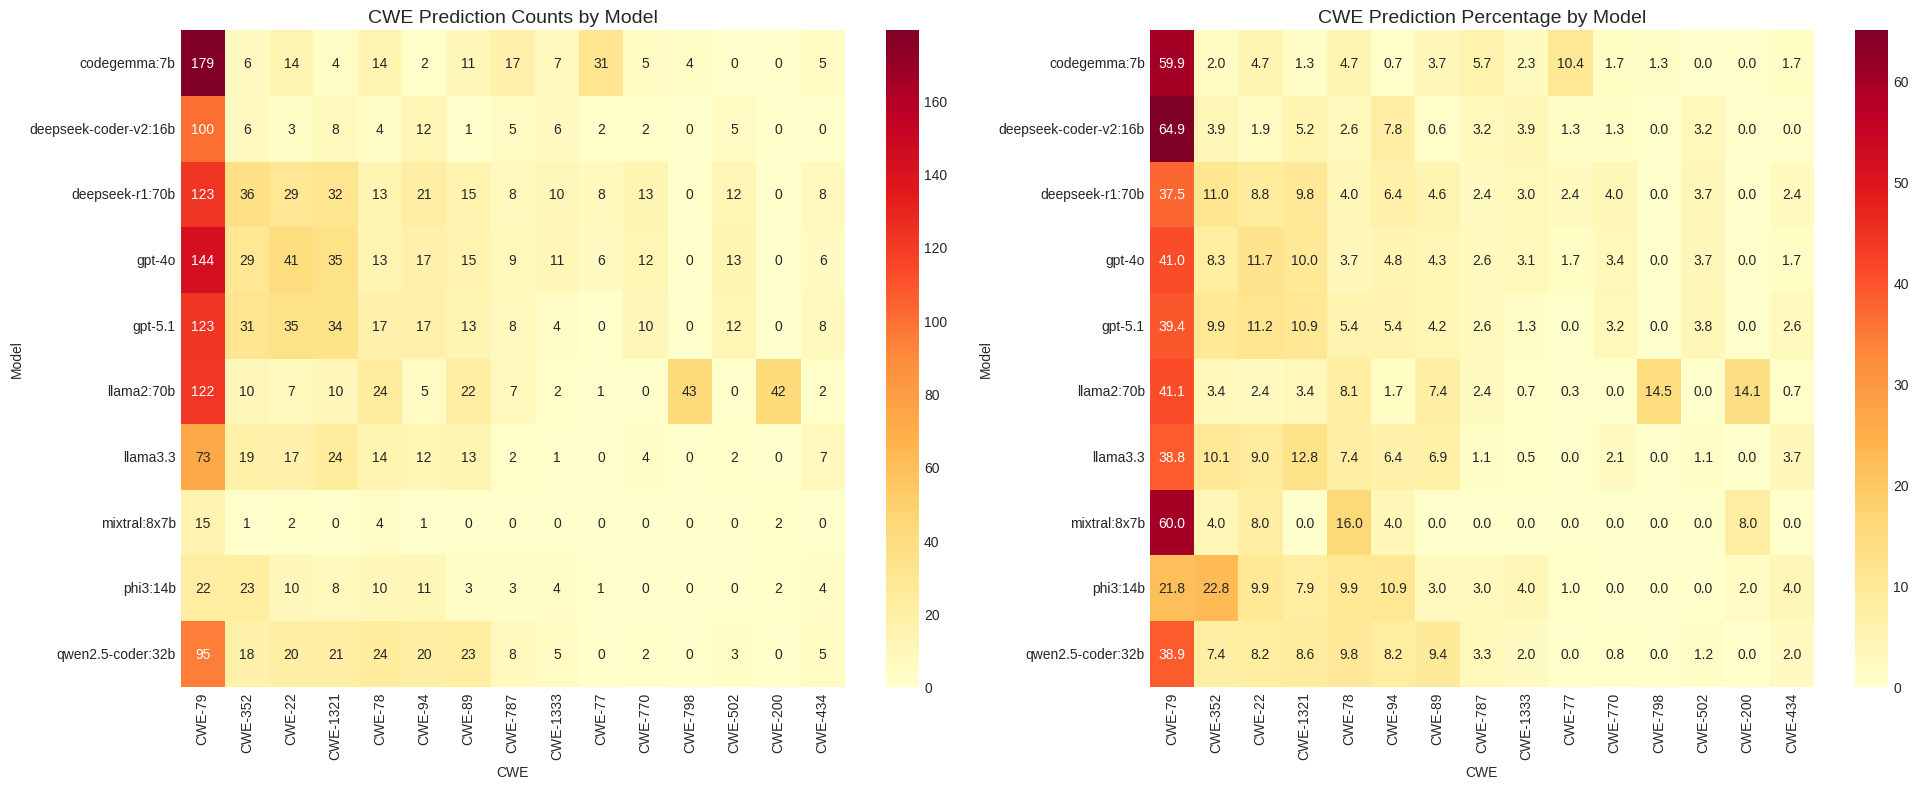

In [11]:
# Create a heatmap of prediction frequencies
def create_prediction_heatmap(prediction_freq, top_n=15):
    """Create a heatmap showing CWE prediction frequencies across models."""
    # Get all CWEs and find top N overall
    all_cwes = Counter()
    for model_freq in prediction_freq.values():
        all_cwes.update(model_freq)
    
    top_cwes = [cwe for cwe, _ in all_cwes.most_common(top_n)]
    models = sorted(prediction_freq.keys())
    
    # Build matrix
    matrix = []
    for model in models:
        row = [prediction_freq[model].get(cwe, 0) for cwe in top_cwes]
        matrix.append(row)
    
    df = pd.DataFrame(matrix, index=models, columns=top_cwes)
    
    # Normalize by row (percentage of model's predictions)
    df_normalized = df.div(df.sum(axis=1), axis=0) * 100
    
    return df, df_normalized


freq_df, freq_df_normalized = create_prediction_heatmap(prediction_freq, top_n=15)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Raw counts
sns.heatmap(freq_df, annot=True, fmt='d', cmap='YlOrRd', ax=axes[0])
axes[0].set_title('CWE Prediction Counts by Model', fontsize=14)
axes[0].set_xlabel('CWE')
axes[0].set_ylabel('Model')

# Normalized
sns.heatmap(freq_df_normalized, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1])
axes[1].set_title('CWE Prediction Percentage by Model', fontsize=14)
axes[1].set_xlabel('CWE')
axes[1].set_ylabel('Model')

plt.tight_layout()
plt.show()

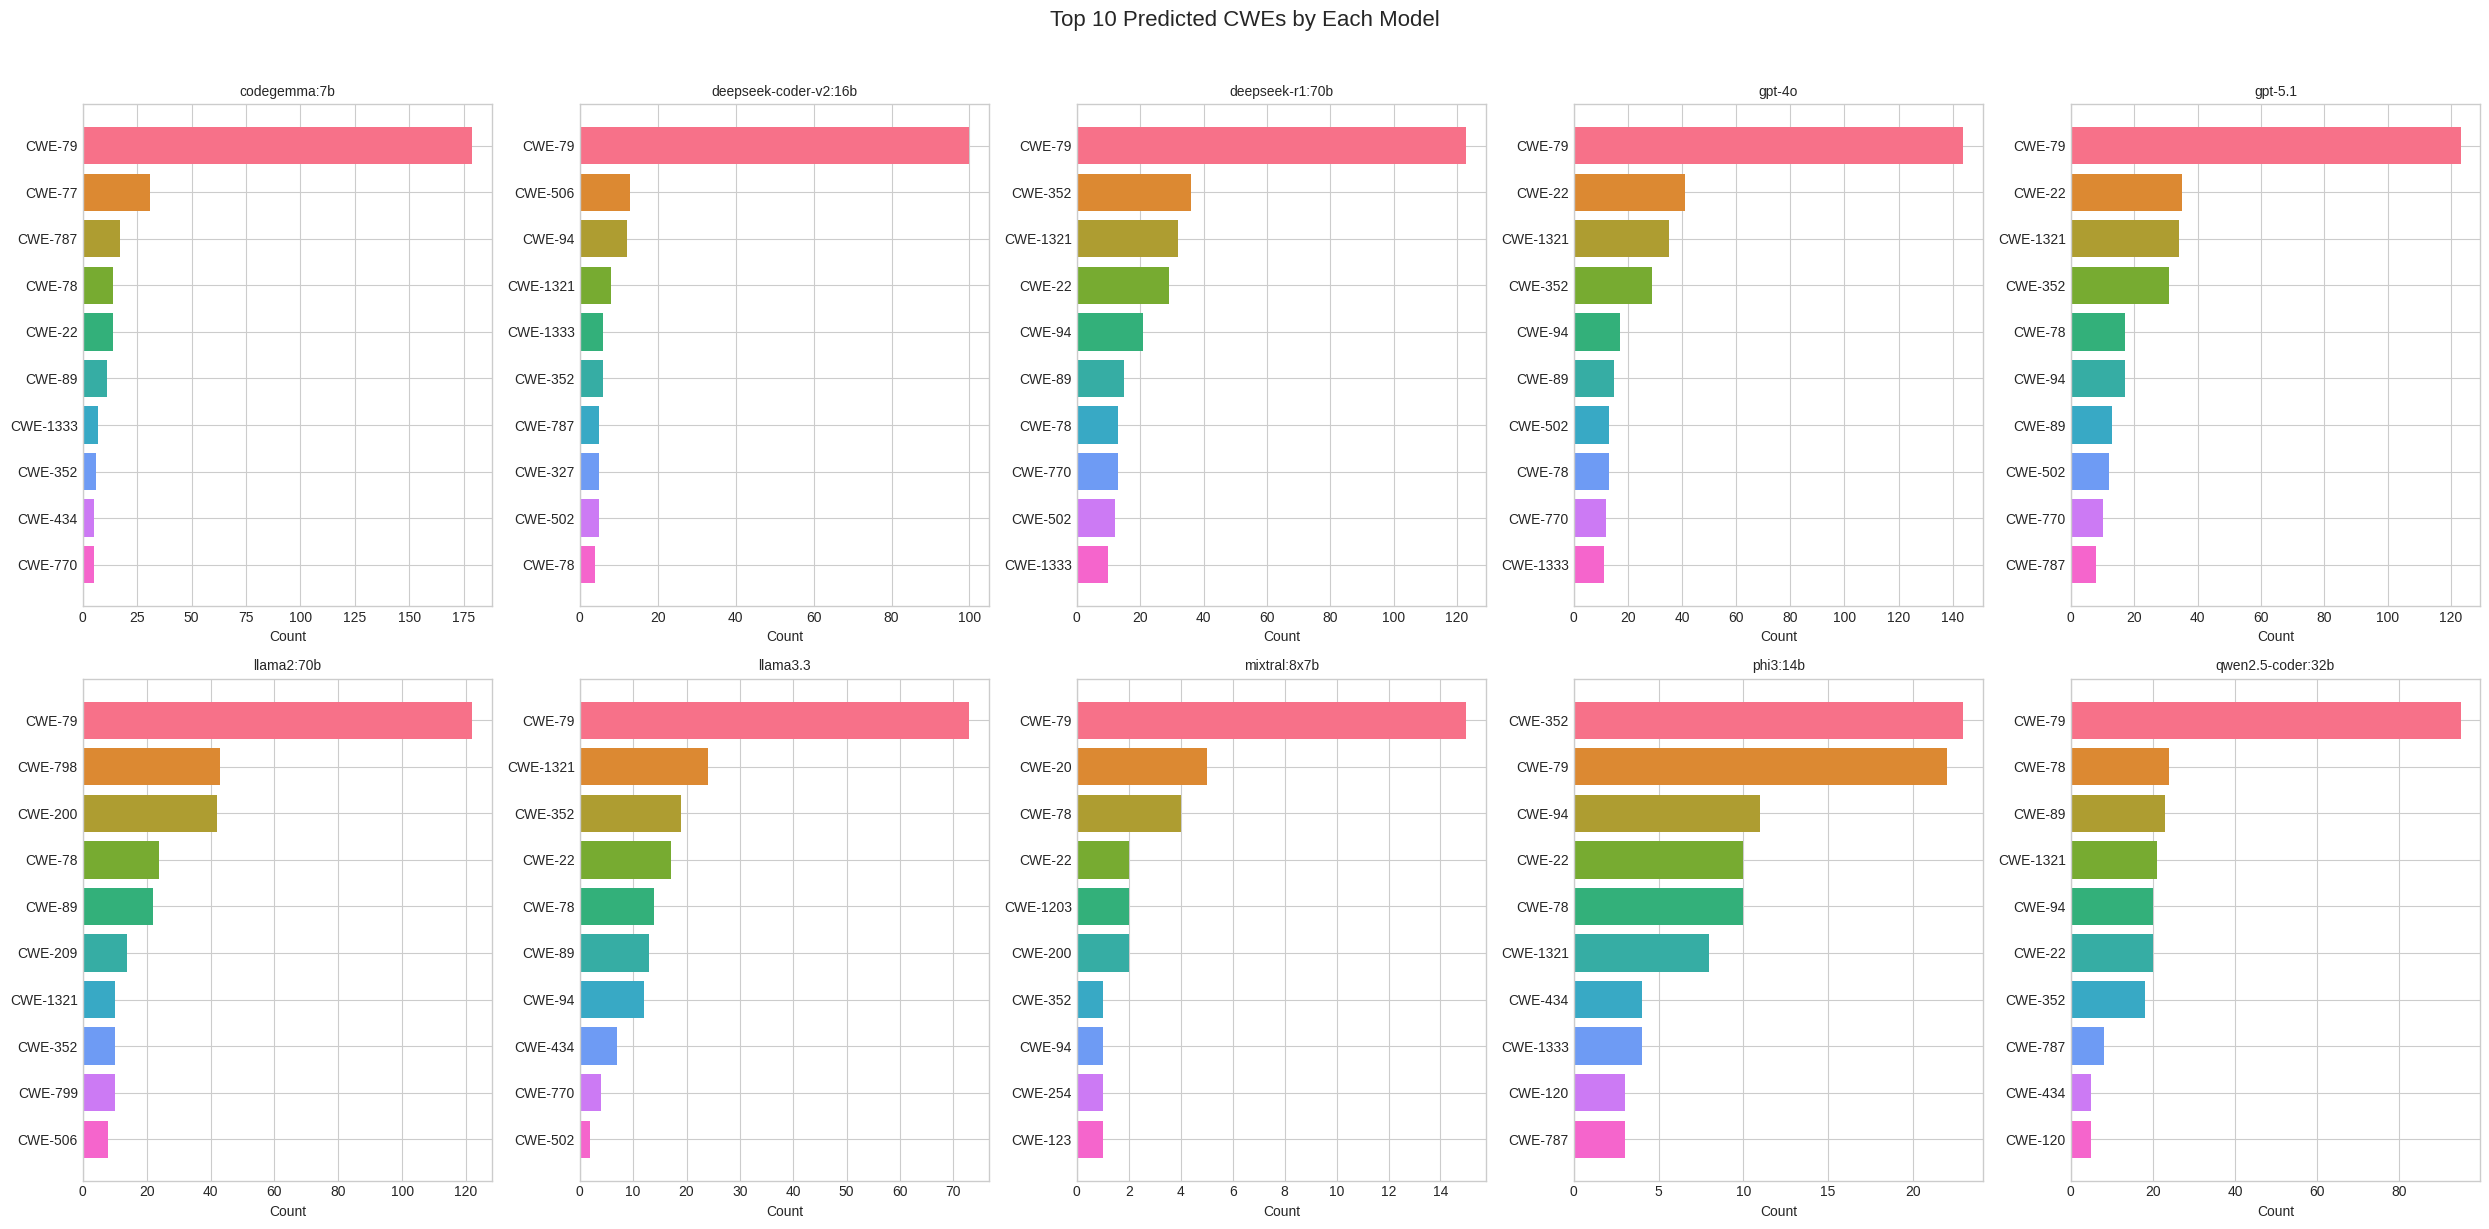

In [12]:
# Bar chart showing prediction distribution for each model
fig, axes = plt.subplots(2, 5, figsize=(25, 12))
axes = axes.flatten()

models = sorted(prediction_freq.keys())

for idx, model in enumerate(models):
    if idx >= len(axes):
        break
    
    top_cwes = prediction_freq[model].most_common(10)
    if top_cwes:
        cwes, counts = zip(*top_cwes)
        colors = sns.color_palette('husl', len(cwes))
        axes[idx].barh(range(len(cwes)), counts, color=colors)
        axes[idx].set_yticks(range(len(cwes)))
        axes[idx].set_yticklabels(cwes)
        axes[idx].invert_yaxis()
        axes[idx].set_xlabel('Count')
        axes[idx].set_title(f'{model}', fontsize=10)

# Hide unused axes
for idx in range(len(models), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Top 10 Predicted CWEs by Each Model', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 6. Misclassification Analysis

Analyze common misclassification patterns for each model.

In [13]:
# Filter to only cases where a prediction was made and we have ground truth
valid_predictions = classification_df[
    classification_df['predicted_cwe'].notna() & 
    classification_df['ground_truth_cwes'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False)
].copy()

# Add normalized CWE columns for consistent analysis
valid_predictions['actual_cwe_norm'] = valid_predictions['actual_cwe'].apply(normalize_cwe_prediction)
valid_predictions['predicted_cwe_norm'] = valid_predictions['predicted_cwe'].apply(normalize_cwe_prediction)

print(f"Total predictions with ground truth: {len(valid_predictions)}")
print(f"Correct classifications: {(valid_predictions['is_correct'] == True).sum()}")
print(f"Incorrect classifications: {(valid_predictions['is_correct'] == False).sum()}")

Total predictions with ground truth: 2747
Correct classifications: 1626
Incorrect classifications: 1118


In [14]:
# Classification accuracy by model
accuracy_by_model = valid_predictions.groupby('model').agg({
    'is_correct': ['sum', 'count', 'mean']
}).round(3)

accuracy_by_model.columns = ['Correct', 'Total', 'Accuracy']
accuracy_by_model = accuracy_by_model.sort_values('Accuracy', ascending=False)

print("Classification Accuracy by Model:")
print("=" * 50)
print(accuracy_by_model.to_string())

Classification Accuracy by Model:
                      Correct  Total  Accuracy
model                                         
gpt-5.1                   301    340  0.885294
gpt-4o                    329    384  0.856771
llama3.3                  162    194  0.835052
deepseek-r1:70b           297    380  0.781579
qwen2.5-coder:32b         190    261  0.727969
mixtral:8x7b               17     37  0.459459
codegemma:7b              124    321  0.386293
deepseek-coder-v2:16b      79    214  0.369159
phi3:14b                   33    158  0.208861
llama2:70b                 94    455  0.206593


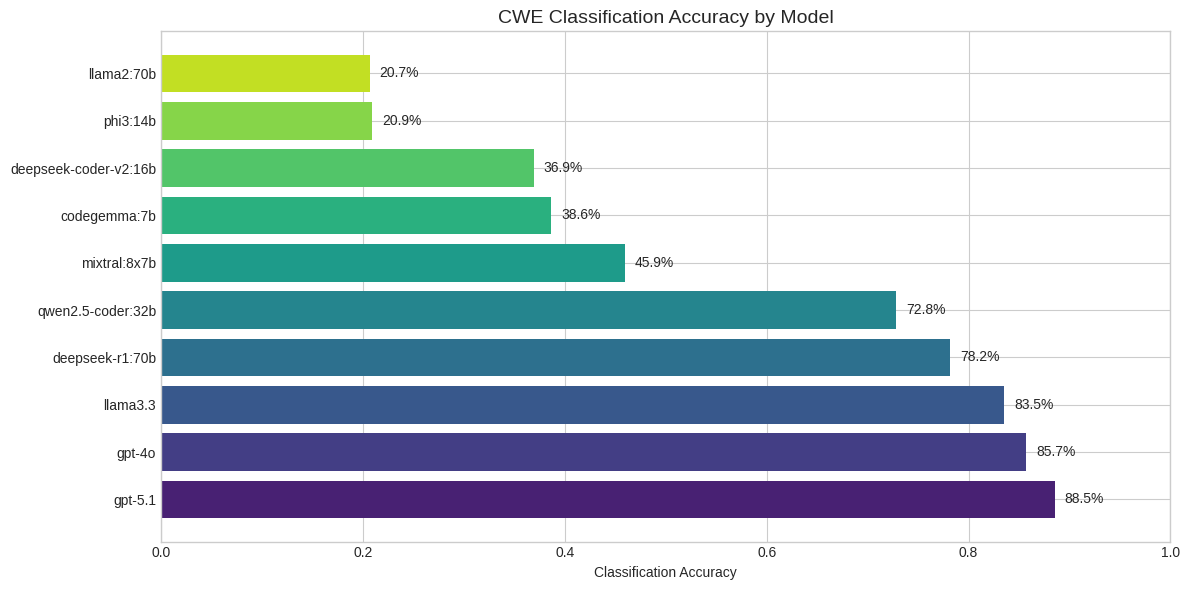

In [15]:
# Plot accuracy comparison
fig, ax = plt.subplots(figsize=(12, 6))

models = accuracy_by_model.index.tolist()
accuracies = accuracy_by_model['Accuracy'].values

colors = sns.color_palette('viridis', len(models))
bars = ax.barh(range(len(models)), accuracies, color=colors)
ax.set_yticks(range(len(models)))
ax.set_yticklabels(models)
ax.set_xlabel('Classification Accuracy')
ax.set_title('CWE Classification Accuracy by Model', fontsize=14)
ax.set_xlim(0, 1)

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    ax.text(acc + 0.01, i, f'{acc:.1%}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

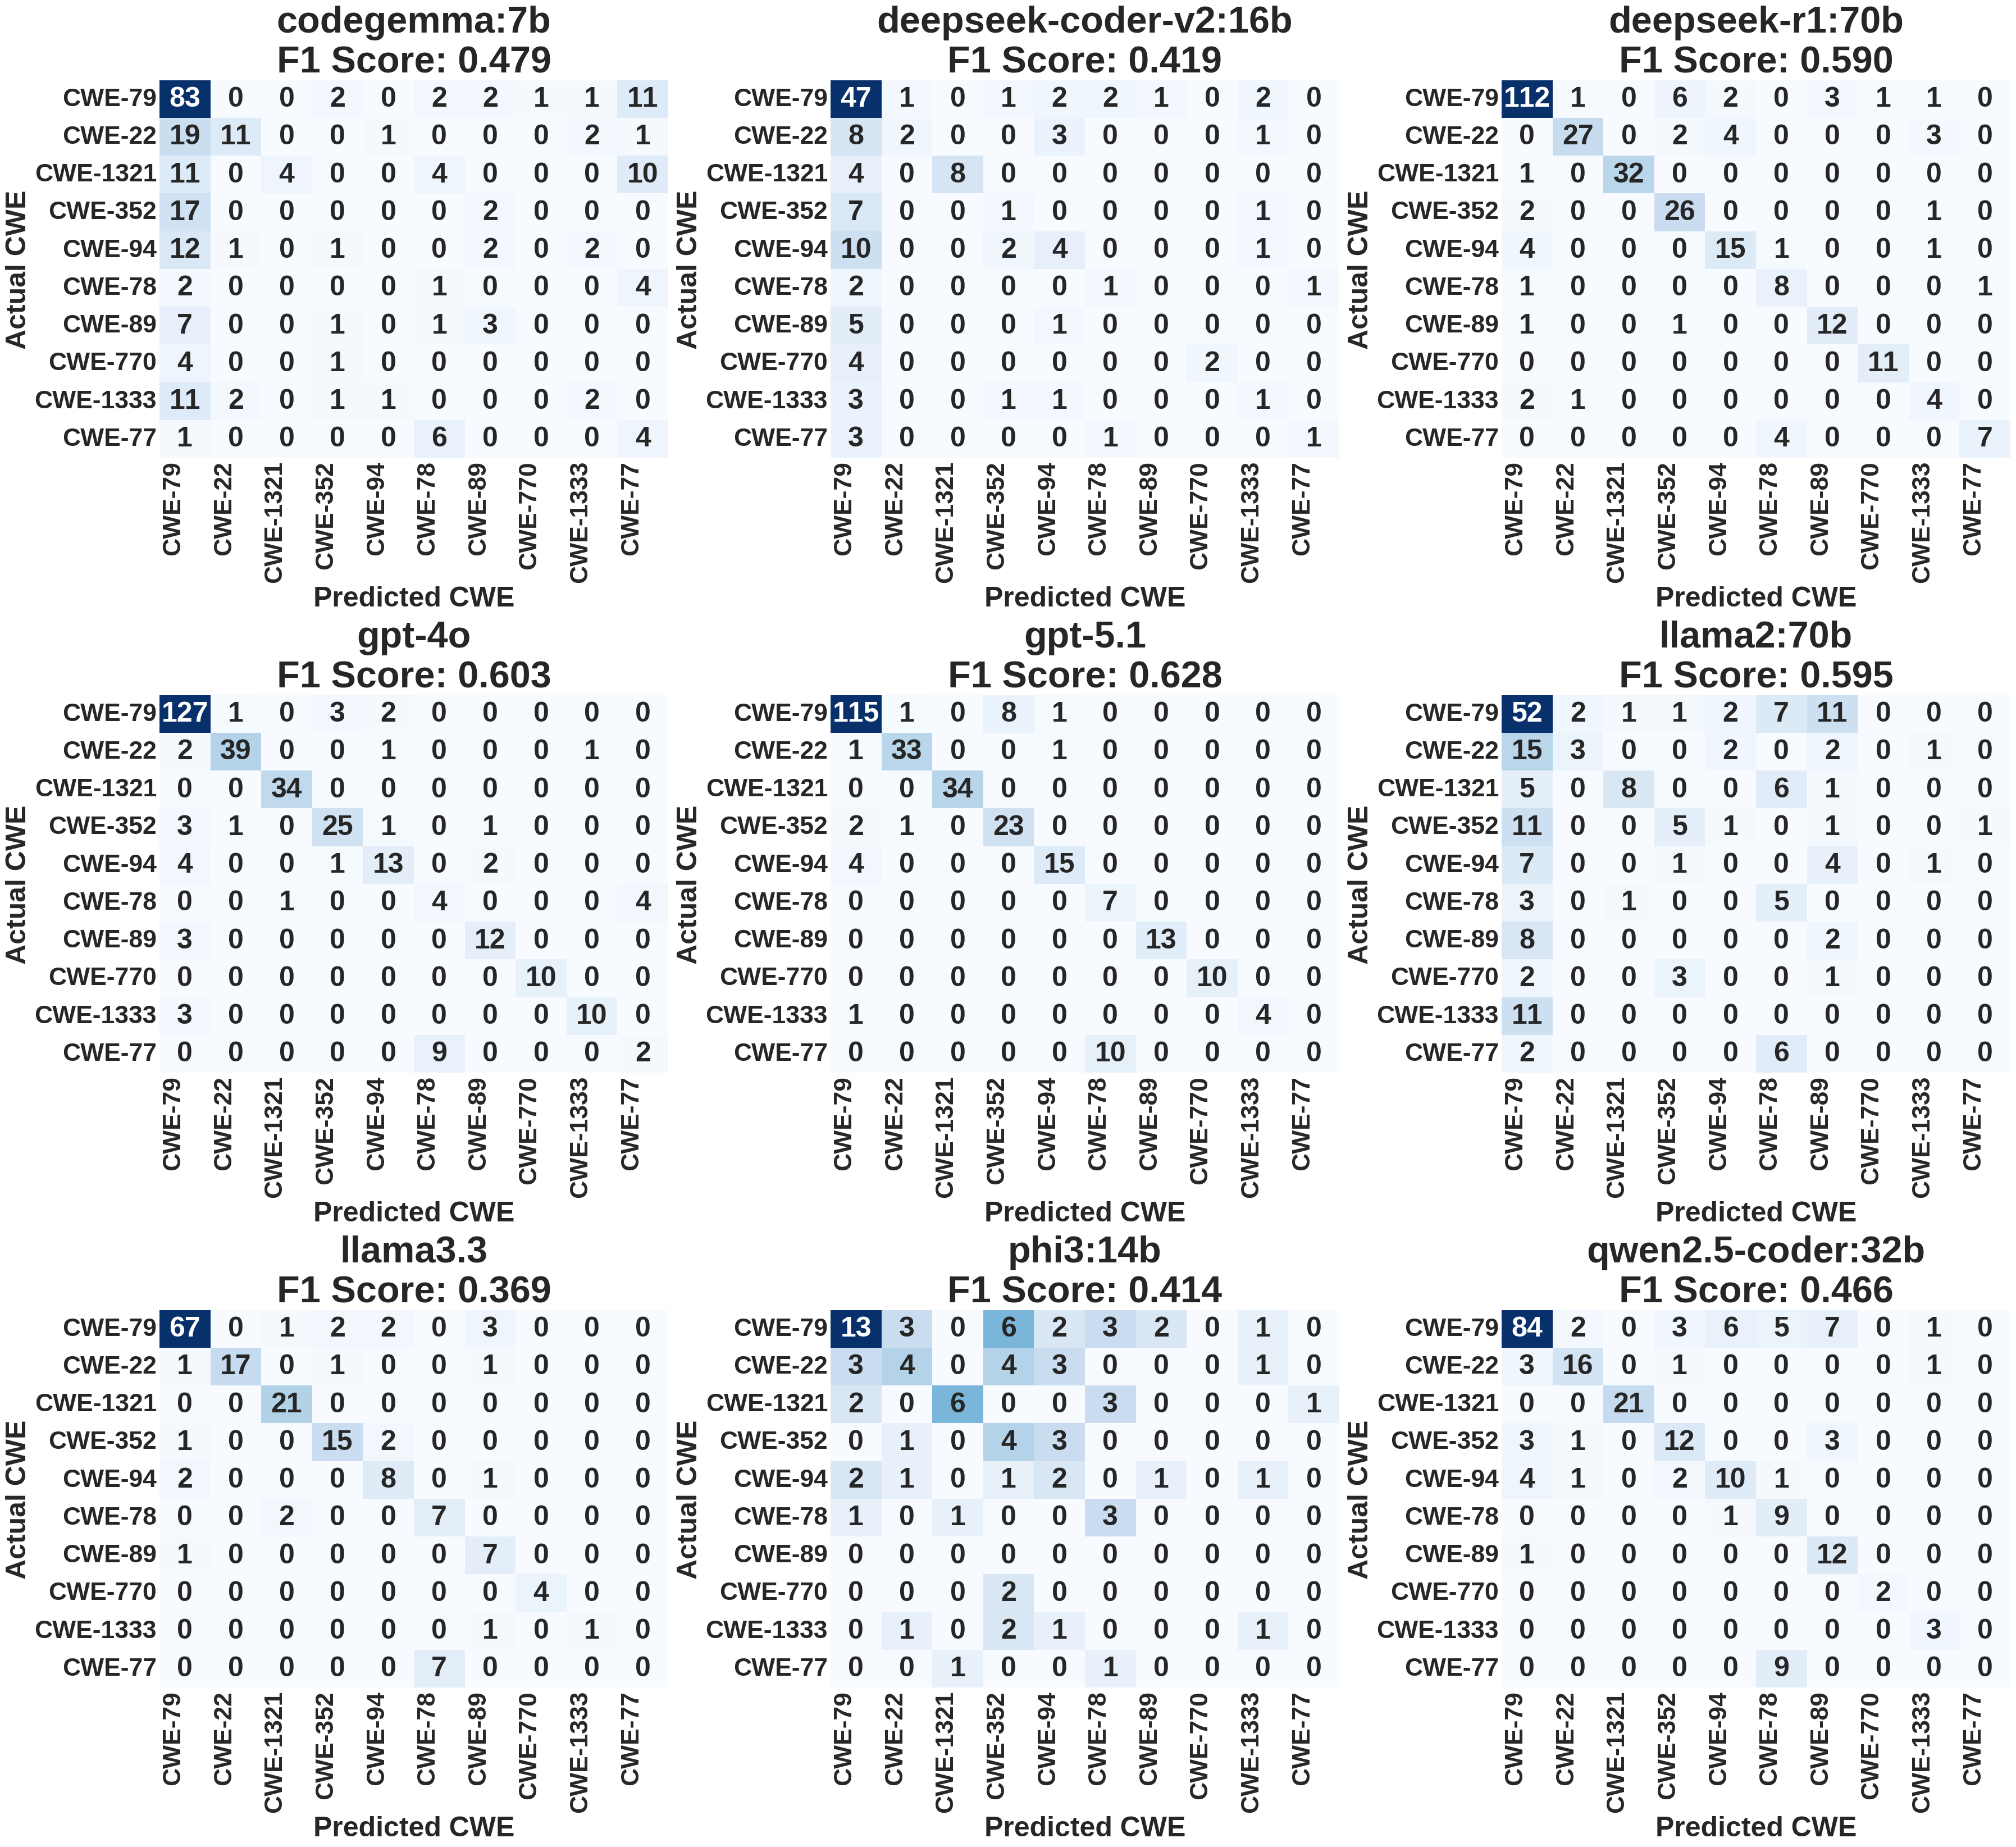

In [18]:
# Create heatmap subplots for ALL models showing Actual vs Predicted CWE
# F1 scores from common vulnerabilities analysis (582 common samples, 1164 total tests)
MODEL_F1_SCORES = {
    'codegemma:7b': 0.479,
    'deepseek-coder-v2:16b': 0.419,
    'deepseek-r1:70b': 0.590,
    'gpt-4o': 0.603,
    'gpt-5.1': 0.628,
    'llama2:70b': 0.595,
    'llama3.3': 0.369,
    'mixtral:8x7b': 0.196,
    'phi3:14b': 0.414,
    'qwen2.5-coder:32b': 0.466,
}

def create_all_models_confusion_heatmaps(valid_predictions, top_n_cwes=10):
    """Create confusion matrix heatmaps for all models in a grid with F1 scores."""
    
    models = sorted(valid_predictions['model'].unique())
    models = [model for model in models if model != 'mixtral:8x7b']

    n_models = len(models)
    
    # Calculate grid dimensions
    n_cols = 3
    n_rows = (n_models + n_cols - 1) // n_cols
    
    # Get top N most common actual CWEs across all models for consistent axes
    all_actual_cwes = valid_predictions['actual_cwe_norm'].value_counts()
    top_actual_cwes = all_actual_cwes.head(top_n_cwes).index.tolist()
    
    # Get top N most common predicted CWEs
    all_pred_cwes = valid_predictions['predicted_cwe_norm'].value_counts()
    top_pred_cwes = all_pred_cwes.head(top_n_cwes).index.tolist()
    
    # Combine for common axis (use union of both)
    common_cwes_set = set(top_actual_cwes) | set(top_pred_cwes)
    
    # Sort by prevalence (combined frequency from actual + predicted counts)
    combined_counts = all_actual_cwes.add(all_pred_cwes, fill_value=0)
    common_cwes = sorted(common_cwes_set, key=lambda x: combined_counts.get(x, 0), reverse=True)[:top_n_cwes]
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12 * n_cols, 11 * n_rows))
    axes = axes.flatten()
    
    for idx, model in enumerate(models):
        model_df = valid_predictions[valid_predictions['model'] == model].copy()
        
        # Get pre-calculated F1 score for this model
        f1 = MODEL_F1_SCORES.get(model, 0.0)
        
        # Filter to common CWEs for visualization
        filtered_df = model_df[
            model_df['actual_cwe_norm'].isin(common_cwes) & 
            model_df['predicted_cwe_norm'].isin(common_cwes)
        ]
        
        if len(filtered_df) == 0:
            axes[idx].text(0.5, 0.5, f'{model}\nNo data', ha='center', va='center', fontsize=32)
            axes[idx].set_title(f'{model}\nF1: {f1:.3f}', fontsize=28)
            continue
        
        # Create confusion matrix
        confusion = pd.crosstab(
            filtered_df['actual_cwe_norm'], 
            filtered_df['predicted_cwe_norm'],
            margins=False
        )
        
        # Reindex to ensure consistent ordering
        confusion = confusion.reindex(index=common_cwes, columns=common_cwes, fill_value=0)
        confusion = confusion.dropna(how='all', axis=0).dropna(how='all', axis=1)
        
        if confusion.empty:
            axes[idx].text(0.5, 0.5, f'{model}\nNo data', ha='center', va='center', fontsize=32)
            axes[idx].set_title(f'{model}\nF1: {f1:.3f}', fontsize=28)
            continue
        
        # Plot heatmap - no colorbar for cleaner look
        sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                    cbar=False, annot_kws={'size': 36, 'fontweight': 'bold'})
        axes[idx].set_title(f'{model}\nF1 Score: {f1:.3f}', fontsize=48, fontweight='bold')
        axes[idx].set_xlabel('Predicted CWE', fontsize=36, fontweight='bold')
        axes[idx].set_ylabel('Actual CWE', fontsize=36, fontweight='bold')
        axes[idx].tick_params(axis='both', labelsize=32)
        
        # Rotate x labels for readability
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=90, ha='right', fontsize=32, fontweight='bold')
        axes[idx].set_yticklabels(axes[idx].get_yticklabels(), rotation=0, fontsize=32, fontweight='bold')
    
    # Hide unused axes
    for idx in range(n_models, len(axes)):
        axes[idx].set_visible(False)
    
    # plt.suptitle('CWE Classification Confusion Matrices by Model\n(Actual vs Predicted)', 
                #  fontsize=24, fontweight='bold', y=1.02)
    plt.tight_layout()
    fig.savefig('llm_cwe_classification_confusion_heatmaps.png', dpi=300, bbox_inches='tight')
    plt.show()


# Create the heatmaps
create_all_models_confusion_heatmaps(valid_predictions, top_n_cwes=10)